## RTML LAB 01 REPORT | st121395 Chanapa Pananookooln

### Evidence of getting VSCode+SSH+Docker working on puffer

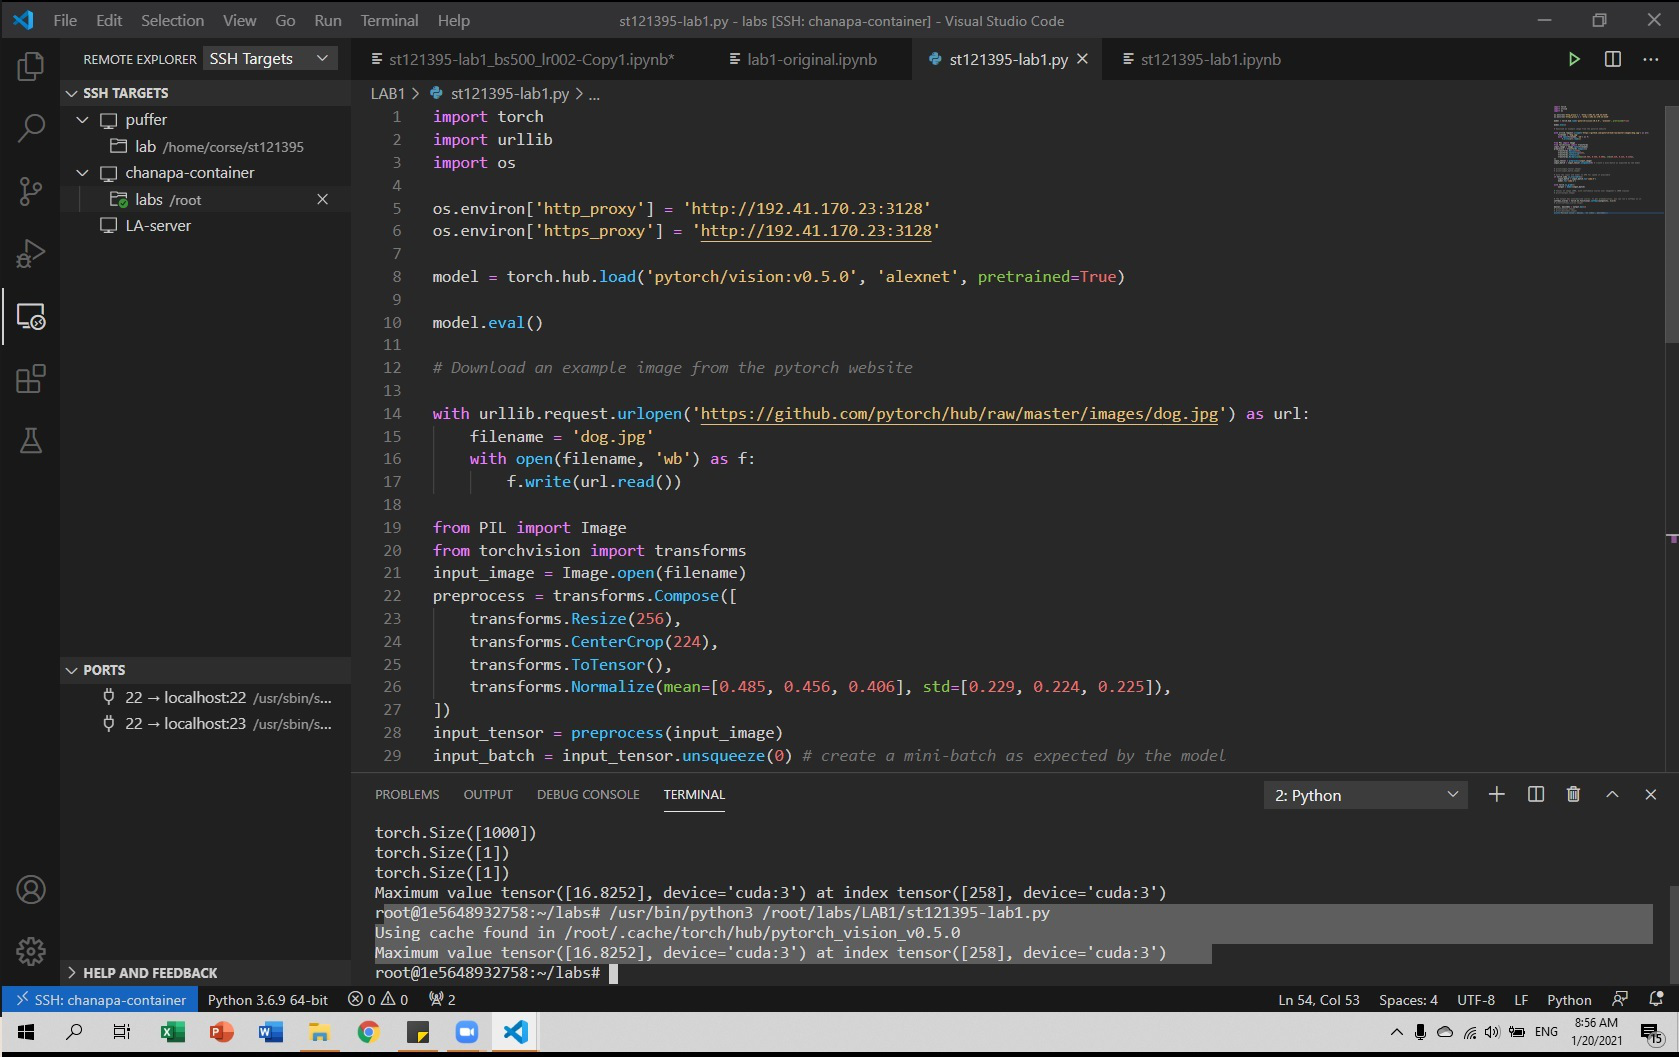

In [1]:
from IPython.display import display
from PIL import Image

display(Image.open("printscreen.jpg"))

### Import & set the free GPU as device

In [2]:
import urllib
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import os
import random
import warnings
warnings.filterwarnings("ignore")

from get_free_gpu import get_free_gpu
from IPython.display import clear_output

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'


# Get free GPU
device = torch.device(get_free_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Device = ",device)

Device =  cuda:0


### Define a function for timing

In [3]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Time the forward run time

In [4]:
# load ALEXNET PRETRAINED model
model_time = torch.hub.load('pytorch/vision:v0.5.0', 'alexnet', pretrained=True)

model_time.eval()

# Download one example image from the pytorch website
with urllib.request.urlopen('https://github.com/pytorch/hub/raw/master/images/dog.jpg') as url:
    filename = 'dog.jpg'
    with open(filename, 'wb') as f:
        f.write(url.read())

# OPEN .jpg file
input_image = Image.open('dog.jpg')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transform .jpg file into TENSOR
input_tensor = preprocess(input_image) 

# resize so that it have 4 dimensions (fist dimension for batch size)
input_batch = input_tensor.unsqueeze(0)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model_time.to('cuda')

# TIME
with torch.no_grad():
    start_time = time.time()
    output = model_time(input_batch) # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    end_time = time.time()

epoch_mins, epoch_secs = epoch_time(start_time, end_time)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
softmax_scores = torch.nn.functional.softmax(output[0], dim=0)

maxval, maxindex = output.max(1)

print('Maximum value', maxval, 'at index', maxindex) # index is the class of the prediction
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')
print("Elapsed time ",end_time - start_time)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


Maximum value tensor([16.8252], device='cuda:0') at index tensor([258], device='cuda:0')
Epoch Time: 0m 0s
Elapsed time  0.0057451725006103516


#### Elapsed time  0.0057451725006103516
#### That is equal to 5.7 milliseconds.

### Define funtions for plotting loss and accuracy as functions of epochs

In [5]:
def do_plot(train_loss_list, val_loss_list):
    plt.figure(figsize=(20,10))
    clear_output(wait=True)
    plt.plot(train_loss_list, label='Train')
    plt.plot(val_loss_list, label='Validation')
    plt.title('Train and Validation Loss')
    plt.xlabel('EPOCH')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [6]:
def do_plot_acc(train_acc_list, val_acc_list):
    plt.figure(figsize=(10,5))
    clear_output(wait=True)
    plt.plot(train_acc_list, label='Train')
    plt.plot(val_acc_list, label='Validation')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('EPOCH')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Load the model
I did a seach for how to apply the AlexNet pre-trained model that was trained on 1000 classes with the CIFAR-10 dataset which has only 10 classes.

Their method is to change the architectire of the last few fully connected layers, so I followed them accordingly.

Reference : https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy?fbclid=IwAR17SCl6SUBoAdTyNtoqjQiERfUwwhFV_BCi-w9y2AfsimbReyZ9-Mf23Ns

In [7]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'alexnet', pretrained=True)
model.eval()

# print to see the architecture of the model
# print(model)

# Adapt some layers and also the last layer to get 10-way-softmax at the last layer
model.classifier[1] = nn.Linear(9216,4096)
model.classifier[4] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,10)

model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [8]:
# Define data transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # because i'm using Pre-trained model
])

## Load CIFAR-10 dataset

In [9]:
from torch.utils.data import TensorDataset

# Define dataset by loading CIFAR-10 data set with torchvision
# PATH OK!
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)

valid_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=preprocess)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=preprocess)

BATCH_SIZE = 200

# Use Dataloader to load the Train, Validation and Test set in batches

#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_ds, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, pin_memory = True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_ds, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, pin_memory = True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_ds, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, pin_memory = True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Define Loss Function and the Optimizer

In [10]:
# CrossEntropyLoss = NLLLoss + Softmax
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# use stochastic gradient descent
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

In [11]:
# I used only 20 EPOCHs
num_epochs = 20

## Training & Validation

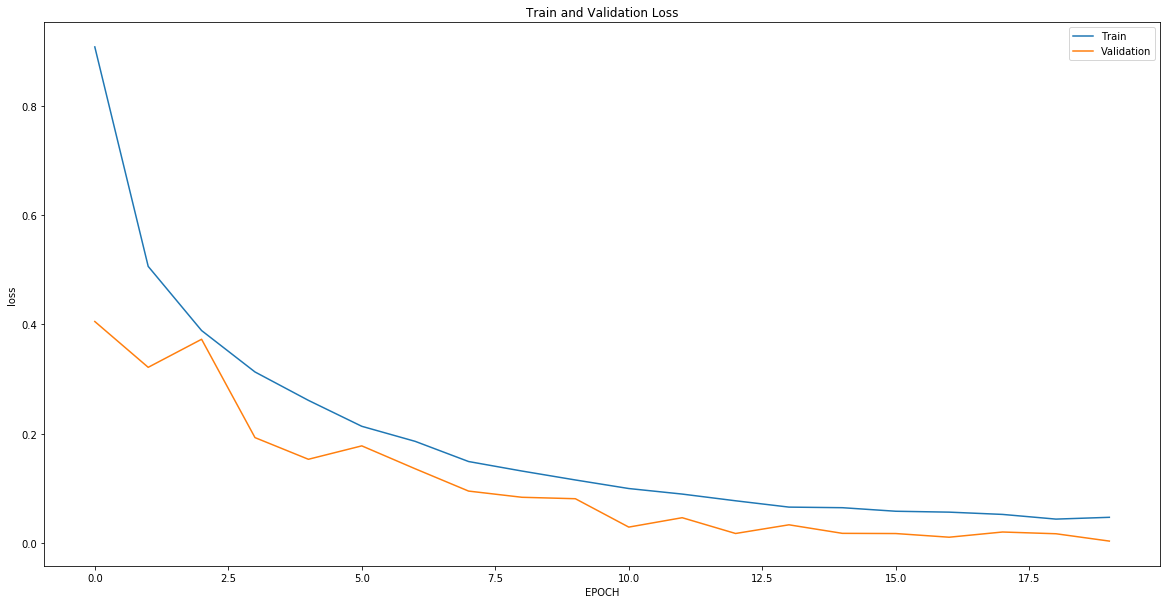

	Train Loss: 0.046 | Train Acc: 98.83%
	 Val. Loss: 0.003 |  Val. Acc: 100.00%


In [12]:
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    
    # ==================== TRAINING =====================
    
    train_total = 0
    train_correct = 0
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    print(f"Training ... EPOCH : {epoch}")
    
    for num_batch,(batch, labels) in enumerate(train_iterator):
        
        #Move tensors to device
        batch = batch.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = model(batch.float())
        outputs = F.softmax(outputs)
        _, predicted = torch.max(outputs.data, 1) #returns (max value, indices) => index is the predicted class        
        
        train_total += labels.size(0)  #keep track of total number of samples
        train_correct += (predicted == labels).sum().item()  #.item() give the raw number without all the extra data
        
        train_acc = 100 * (train_correct / train_total)

        train_epoch_loss += loss.item()
        train_epoch_acc = train_acc
        
    train_loss = train_epoch_loss / len(train_iterator)
    train_acc = train_epoch_acc        
        
        
    # ==================== VALIDATION =====================
    model.eval() 

    val_total = 0
    val_correct = 0
    valid_epoch_loss = 0
    valid_epoch_acc = 0
    
       
    with torch.no_grad():
    
        for num_batch, (batch, labels) in enumerate(valid_iterator):
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            outputs = model(batch.float())
            loss = criterion(outputs, labels)
            
            
            outputs = F.softmax(outputs)
            _, predicted = torch.max(outputs.data, 1)  #returns max value, indices
            
            val_total += labels.size(0)  #keep track of total
            val_correct += (predicted == labels).sum().item()  #.item() give the raw number
            
            val_acc = 100 * (val_correct / val_total)
            
            valid_epoch_loss += loss.item()
            valid_epoch_acc = val_acc
            break # I only do validation on 1 batch of Validation set for faster training time
        
        valid_loss = valid_epoch_loss
        valid_acc = valid_epoch_acc
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    
    # ================ SAVE THE MODEL CHECKPOINTS ==================
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Model:{} saved.".format(type(model).__name__))
        torch.save(model.state_dict(), 'checkpoint_bs200_lr001.pth.tar')

    # ================ PLOT THE LOSS AND PRINT THE ACCURACY ==================
    do_plot(train_loss_list, valid_loss_list)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_epoch_acc:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_epoch_acc:.2f}%')

### Plot Accuracy with EPOCH

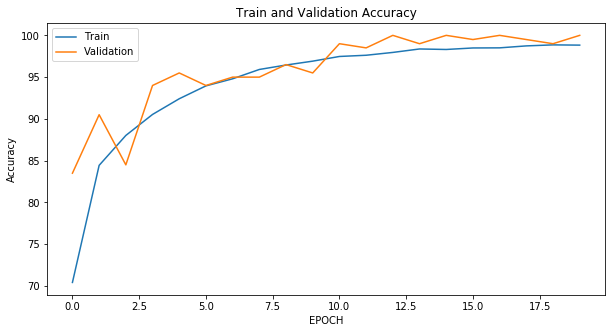

In [13]:
do_plot_acc(train_acc_list, valid_acc_list)

### Comparing the predicted class with the actual class on Validation Set

In [14]:
print("============= Actual Y ==============")
print(labels)

print("============= Predicted Y ==============")
print(predicted)

print("========== VALIDATION Accuracy =========")
print(f"{val_acc} %")

#The model is doing very well in predicting the class of the validation set

============= Actual Y ==============
tensor([7, 3, 7, 9, 5, 9, 0, 2, 2, 7, 0, 4, 0, 6, 5, 6, 6, 1, 5, 1, 6, 1, 7, 5,
        8, 0, 8, 9, 0, 1, 4, 6, 2, 2, 5, 9, 0, 2, 4, 8, 4, 5, 1, 0, 9, 2, 6, 8,
        2, 2, 8, 6, 7, 2, 8, 2, 5, 0, 7, 6, 2, 9, 4, 4, 4, 5, 2, 2, 5, 6, 4, 7,
        6, 6, 9, 3, 6, 2, 8, 7, 8, 2, 6, 2, 6, 9, 9, 7, 1, 1, 9, 1, 5, 7, 6, 3,
        8, 5, 2, 0, 4, 0, 1, 2, 0, 8, 6, 5, 7, 3, 4, 4, 1, 8, 0, 4, 7, 5, 4, 9,
        7, 2, 9, 2, 0, 2, 1, 3, 2, 4, 1, 7, 0, 5, 8, 2, 9, 0, 2, 9, 4, 4, 8, 8,
        8, 7, 9, 7, 0, 6, 1, 7, 3, 7, 6, 5, 9, 1, 7, 6, 6, 6, 1, 1, 5, 8, 5, 7,
        6, 1, 3, 9, 7, 5, 0, 4, 7, 2, 1, 6, 9, 2, 5, 7, 7, 1, 7, 1, 5, 4, 6, 5,
        8, 0, 3, 3, 8, 3, 8, 7], device='cuda:0')
============= Predicted Y ==============
tensor([7, 3, 7, 9, 5, 9, 0, 2, 2, 7, 0, 4, 0, 6, 5, 6, 6, 1, 5, 1, 6, 1, 7, 5,
        8, 0, 8, 9, 0, 1, 4, 6, 2, 2, 5, 9, 0, 2, 4, 8, 4, 5, 1, 0, 9, 2, 6, 8,
        2, 2, 8, 6, 7, 2, 8, 2, 5, 0, 7, 6, 2, 9, 4, 4, 4, 5, 2, 2, 5, 

### Testing the model with the Test Set

In [19]:
model_load = torch.hub.load('pytorch/vision:v0.5.0', 'alexnet', pretrained=False)
model_load.eval()

model_load.classifier[1] = nn.Linear(9216,4096)
model_load.classifier[4] = nn.Linear(4096,1024)
model_load.classifier[6] = nn.Linear(1024,10)

model_load = model_load.to(device)

model_load.load_state_dict(torch.load('labs/weights/alexnet/alexnet_checkpoint_bs200_lr001.pth.tar')) # PATH OK!

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


<All keys matched successfully>

In [20]:
test_total = 0
test_correct = 0
test_epoch_loss = 0
test_epoch_acc = 0

with torch.no_grad():
    
        for num_batch, (batch, labels) in enumerate(test_iterator):
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            outputs = model(batch.float())
            loss = criterion(outputs, labels)

            outputs = F.softmax(outputs)
            _, predicted = torch.max(outputs.data, 1)  #returns max value, indices
            test_total += labels.size(0)  #keep track of total
            test_correct += (predicted == labels).sum().item()  #.item() give the raw number
            test_acc = 100 * (test_correct / test_total)
            
            test_epoch_loss += loss.item()
            test_epoch_acc += test_acc
        
        test_loss = test_epoch_loss / len(test_iterator)
        test_acc = test_epoch_acc / len(test_iterator)
        
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

Test Loss: 0.446 | Test Acc: 89.53%


### Comparing the predicted class with the actual class on Validation Set

In [21]:
print("============= Actual Y ==============")
print(labels)

print("============= Predicted Y ==============")
print(predicted)

print("========== TEST Accuracy =========")
print(f"{test_acc} %")

============= Actual Y ==============
tensor([0, 3, 0, 5, 8, 7, 2, 3, 9, 0, 8, 3, 0, 2, 7, 1, 7, 9, 7, 9, 6, 2, 2, 8,
        1, 7, 9, 7, 7, 5, 2, 3, 6, 3, 9, 4, 8, 8, 2, 2, 2, 4, 9, 1, 5, 6, 3, 6,
        8, 9, 5, 2, 9, 7, 9, 1, 9, 9, 6, 4, 1, 0, 5, 9, 8, 0, 8, 3, 9, 0, 7, 2,
        6, 8, 0, 0, 4, 6, 7, 1, 3, 7, 9, 0, 0, 6, 5, 4, 0, 5, 7, 0, 8, 3, 2, 3,
        2, 1, 9, 2, 4, 6, 4, 4, 1, 1, 0, 3, 3, 1, 6, 5, 9, 4, 1, 4, 1, 0, 4, 6,
        8, 4, 4, 9, 8, 4, 8, 5, 7, 2, 4, 5, 1, 8, 3, 1, 3, 6, 1, 5, 6, 4, 2, 1,
        8, 5, 0, 6, 3, 5, 3, 2, 4, 6, 6, 1, 4, 1, 1, 6, 1, 8, 8, 2, 3, 2, 9, 8,
        7, 2, 7, 8, 4, 5, 0, 8, 6, 2, 9, 7, 2, 9, 0, 4, 3, 7, 4, 9, 1, 5, 0, 4,
        0, 5, 0, 8, 5, 4, 8, 5], device='cuda:0')
============= Predicted Y ==============
tensor([0, 3, 2, 5, 8, 7, 0, 3, 9, 0, 8, 3, 0, 2, 7, 1, 7, 9, 7, 9, 6, 2, 4, 8,
        1, 7, 9, 7, 7, 4, 2, 3, 6, 3, 9, 4, 8, 0, 2, 2, 2, 4, 9, 1, 5, 4, 3, 6,
        8, 9, 5, 2, 9, 7, 9, 9, 9, 9, 6, 4, 1, 0, 5, 9, 8, 0, 8, 0, 9, 

## Display the incorrectly clasified images

In [23]:
# classes of CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'fog', 'horse', 'ship', 'truck']

In [53]:
incorrect_im = batch[labels!=predicted].cpu().detach().numpy()

incorrect_im = np.transpose(incorrect_im, (0,2,3,1))
incorrect_im = (1/(2*2.25)) * incorrect_im + 0.5

real_label = labels[labels!=predicted].cpu().detach().numpy()
predicted_label = predicted[labels!=predicted].cpu().detach().numpy()

real_label = [ classes[i] for i in real_label]
predicted_label = [ classes[i] for i in predicted_label]

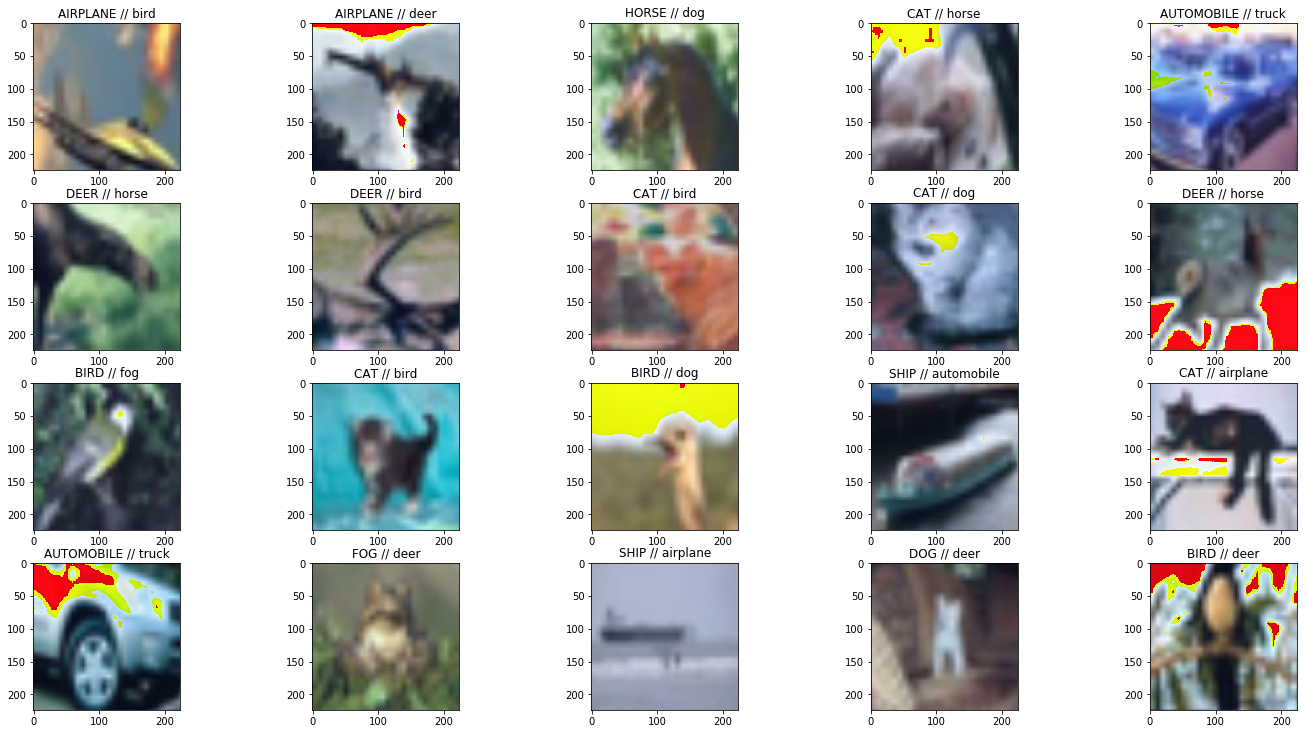

In [69]:
import numpy as np
import matplotlib.pyplot as plt

rows = 4
cols = 5
axes = []
fig = plt.figure(figsize=(20,10))

for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = (f"{real_label[-a].upper()} // {predicted_label[-a]}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(incorrect_im[-a])
fig.tight_layout(pad=0)    
plt.show()

# Real labels are displayed in UPPERCASE
# Predicted labels are displayed in lowercase
# REALLABEL // predicted

# LAB REPORT

### Introduction
The goal of this lab is to use the AlexNet model to classify the images in CIFAR-10 dataset.

AlexNet model is a large CNN model with 5 convolutional layers followed by 3 fully connected layers.
This model introduces the significant benefits of ReLu non-linear activation function, Local response normalization, overlapping pooling and dropout.

Originally, AlexNet model is trained for classifying 1000 different classes. When we load the model from pytorch we have the choice to load only the architecture or also their Pre-trained weights.

The problem is that the CIFAR-10 dataset that we want to use the AlexNet on contains only 10 classes of images so I did some search on what is the trick to use the AlexNet model on this data set and found a method from Kaggle that we can change the architecture of the last few fully connected layers in the Classifier part so that we can end the model with 10-way softmax.

### Method
I chose to load the Pre-trained model and I followed the method from Kaggle to modified the layers accordingly :

    model.classifier[1] = nn.Linear(9216,4096)
    model.classifier[4] = nn.Linear(4096,1024)
    model.classifier[6] = nn.Linear(1024,10)
    
As for the dataset, since CIFAR-10 comes in different sizes I resize the images to 256 and did data augmentation by using RandomCrop to size 224 so that they match the input size for the AlexNet model. I also Normalize the data with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Then, I load the data in batches and feed them to the training and validation loop to fine-tune the model.

These are the configurations of my training loop :

20 EPOCH | batch size = 200 | SGD with momentum = 0.9 | Loss Function = CrossEntropyLoss

I used CrossEntropyLoss because we are doing multiclass classification and this loss function already conbined LogSoftmax and NLLLoss.
So I only need to apply softmax and torch.max when I need the predicted labels to get the accuracy of the model.

For me, one training loop takes very long so I only tried changing one hyperparameter which is the learnig rate.
I used 2 different learning rate while keeping the model architecture and all other configurations constant.

### Results
As shown in this notebook, these are the results when I use learning rate = 0.01. 

    Train Loss: 0.046 | Train Acc: 98.83%
    Val. Loss: 0.003 |  Val. Acc: 100.00%
    Test Loss: 0.446 | Test Acc: 89.53%   
    
In another experiment I changed the learning rate to 0.02. These are the results:
   
    Train Loss: 0.057 | Train Acc: 98.63%
    Val. Loss: 0.023 |  Val. Acc: 99.50%
    Test Loss: 0.514 | Test Acc: 87.68%
    

### Conclusion
Using learning rate of 0.01 or 0.02 we got test set accuracy of 89% and 87%, respectively. I think the high accuracy is because of using Pre-trained weights.

With learning rate of 0.01 I got higher test accuracy than with learning rate of 0.02. This might be because the model is reaching convergence so the learning rate of 0.02 might be too big for the latter epochs.
    
I also tried to display the incorrectly classified images to analyse the errors that the classifier makes on the test set.

Some of the incorrectly classified images are very similar to another class. Sometimes because of the part that was cropped from RandomCrop.
For example, AUTOMOBILE // truck, DEER // horse, CAT // dog. In these images the cropped images looks ery similar to the other class.

But there are also some incorrectly classified images that, in my opinion, the predicted labels are very far off from the real labels.
For example, BIRD // dog, DOG // deer. This might indicate that the model can learn more.

There are many methods we can use to improve the model or fine-tuning it even more.

    - Exepriment with other Data Augmentation ex. RandomRotate, HorizontalFlip to generate more data in the training set.
    - Experiment different ways of adapting the architecture of the fully connected layers
    - Experiment with other optimizer alogorithm such as Adam
    - Experiment with different learning rates
    - Increase the number of Epochs
    - Try to calculate the top-5 and top-1 error rates to see another view of the accuacy
    - Try starting form a non-trained model

In this first lab, I learned a lot about setting up remote SSH and also about images, dockers and containers.

In the machine learning part, I learned how to load and use Pre-design and Pre-trained model, also about the CIFAR-10 dataset.

It is my first time training a model this big and on large public dataset so the runtime is overwhelming for me, I hope to keep learning more and more tricks about CPU and GPU management. I also learned about the deeper convolutional neural network and how they implement their architecture in pytorch from when I printed out the model architecture. I learned about adapting the pre-trained model to other datasets.
I also hope I can experiment more with the hyperparameters in the model with the knowledge from the AlexNet paper.

Notes : I did not set up tensorboard yet but I will make sure to set it up before the next lab!